# Predict Loan Eligibility for Dream Housing Finance


Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 



Data Dictionary
Train file: CSV containing the customers for whom loan eligibility is known as 'Loan_Status'

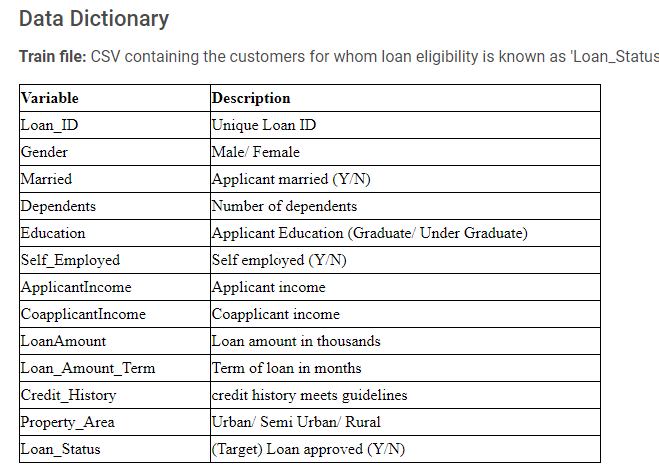


Test file: CSV containing the customer information for whom loan eligibility is to be predicted

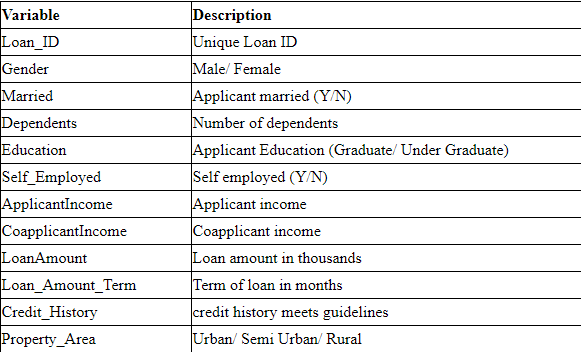


Submission file format

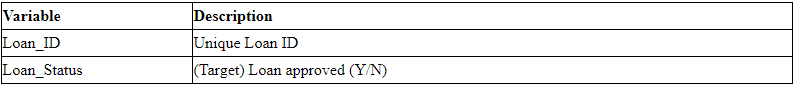


# import libraries 📕📗📘

In [ ]:
import os #paths to file
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter


#ploting libraries
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns

#relevant ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
matplotlib.rcParams['figure.figsize'] =[10,8]
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['font.family'] = 'sans-serif'

#warning hadle
warnings.filterwarnings("ignore")

# load data 📂

In [ ]:
train=pd.read_csv('../input/loan-prediction-analytics-vidhya/train_ctrUa4K.csv')
test=pd.read_csv('../input/loan-prediction-analytics-vidhya/test_lAUu6dG.csv')

# Preprocessing and Data Analysis 💻

## First look at the data

In [ ]:
train.head(5)

In [ ]:
print(f"training set (row, col): {train.shape}\n\ntesting set (row, col): {test.shape}")

In [ ]:
train.info()

In [ ]:
train.describe(include='all')

### 	Show the numerical columns :

In [ ]:
num_columns = [f for f in train.columns if train.dtypes[f] != 'object']
num_columns

### 	Show the categorical columns :

In [ ]:
Categ_columns = [f for f in train.columns if train.dtypes[f] == 'object']
Categ_columns.remove('Loan_ID')
Categ_columns

In [ ]:
train.dtypes.value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',)
plt.title('data type %')

In [ ]:
#the Id column is not needed, let's drop it for both test and train datasets
train=train.drop('Loan_ID',axis=1)
test=test.drop('Loan_ID',axis=1)
#checking the new shapes
print(f"training set (row, col): {train.shape}\n\ntesting set (row, col): {test.shape}")

# finiding missing values

In [ ]:
#missing values in decsending order
train.isnull().sum().sort_values(ascending=False)

In [ ]:
# show the missing value in plot
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### Each value will be replaced by the most frequent value (mode).

In [ ]:
#filling the missing data
print("Before filling missing values \n")

null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


In [ ]:
for col in null_cols:
    print(f"{col}:\n{train[col].value_counts()}\n","-"*50)
    train[col] = train[col].fillna(
    train[col].dropna().mode().values[0] )   


In [ ]:
train.isnull().sum().sort_values(ascending=False)

### check our data after replacing missing value 

In [ ]:
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{ train[col].value_counts()}\n","-"*50)


# Data visalization 📊

In [ ]:
train.hist(figsize=(12,15),edgecolor='black');

split our data to categorical and numerical data,

using the .select_dtypes('dtype').columns.to_list() combination.

In [ ]:
#list of all the numeric columns
num = train.select_dtypes('number').columns.to_list()
#list of all the categoric columns
cat = train.select_dtypes('object').columns.to_list()

#numeric df
train_num =  train[num]
#categoric df
train_cat = train[cat]

In [ ]:
for i in train_num:
    plt.hist(train_num[i])
    plt.title(i)
    plt.show()

In [ ]:
for i in cat[:-1]: 
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x=i ,hue='Loan_Status', data=train )
    plt.xlabel(i, fontsize=14)

# features transformation 

In [ ]:
#converting categorical values to numbers

to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}

# adding the new numeric values from the to_numeric variable to both datasets
train = train.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
test = test.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)

# convertind the Dependents column
Dependents_ = pd.to_numeric(train.Dependents)
Dependents__ = pd.to_numeric(test.Dependents)

# dropping the previous Dependents column
train.drop(['Dependents'], axis = 1, inplace = True)
test.drop(['Dependents'], axis = 1, inplace = True)

# concatination of the new Dependents column with both datasets
train = pd.concat([train, Dependents_], axis = 1)
test = pd.concat([test, Dependents__], axis = 1)

# checking the our manipulated dataset for validation
print(f"training set (row, col): {train.shape}\n\ntesting set (row, col): {test.shape}\n")
print(train.info(), "\n\n", test.info())

In [ ]:
train

# Correlation matrix


In [ ]:
sns.heatmap(train.corr())

## Correlation table 
 

In [ ]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

We can clearly see that Credit_History has the highest correlation with Loan_Status (a positive correlation of 0.54). Therefore our target value is highly dependant on this column.

# Machine learning models

### The Process of Modeling the Data:
1. Importing the model

2. Fitting the model

3. Predicting Loan Status

4. Classification report by Loan Status

5. Overall accuracy

### Models we will use:
- Decision Tree
- Random Forest
- XGBoost
- Logistic Regression

### split data

In [ ]:
x = train.drop('Loan_Status', axis = 1)
y = train['Loan_Status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

## A) Logistic Regression
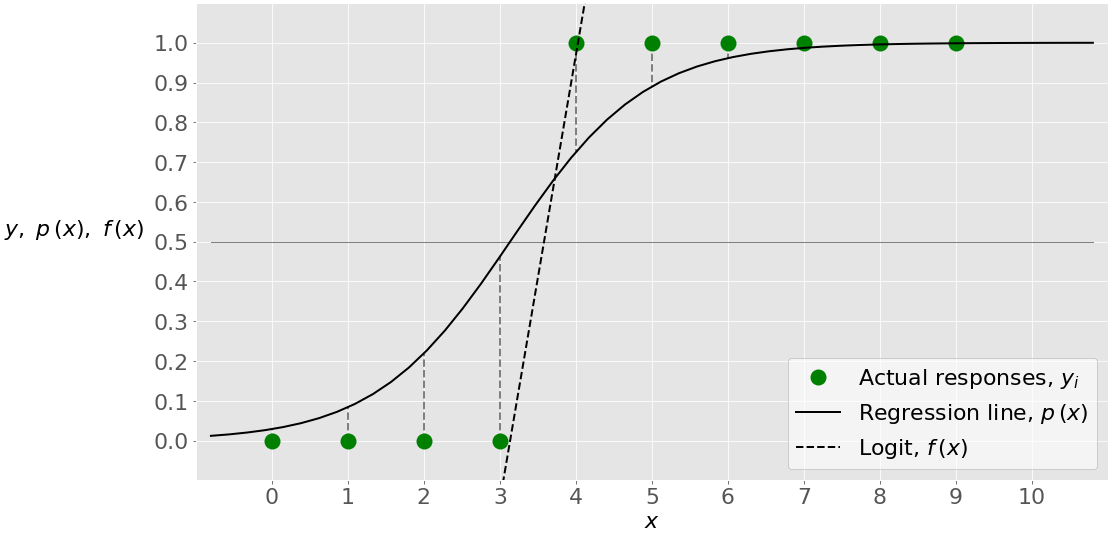

In [ ]:
LR = LogisticRegression()
LR.fit(x_train, y_train)

y_predict = LR.predict(x_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
LR_SC = accuracy_score(y_predict,y_test)
print('accuracy is',accuracy_score(y_predict,y_test)*100)

In [ ]:
Logistic_Regression=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Logistic_Regression.to_csv("Logistic Regression.csv")  

## B) decision tree
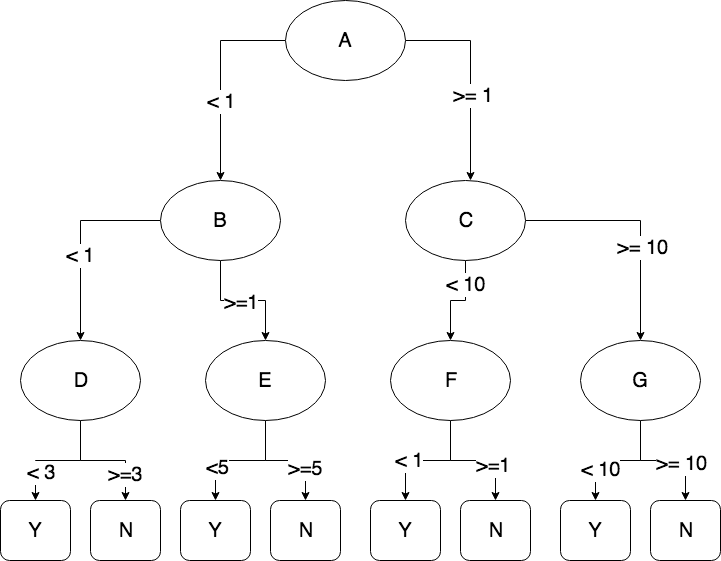

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)

y_predict = DT.predict(x_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

## Random Forest
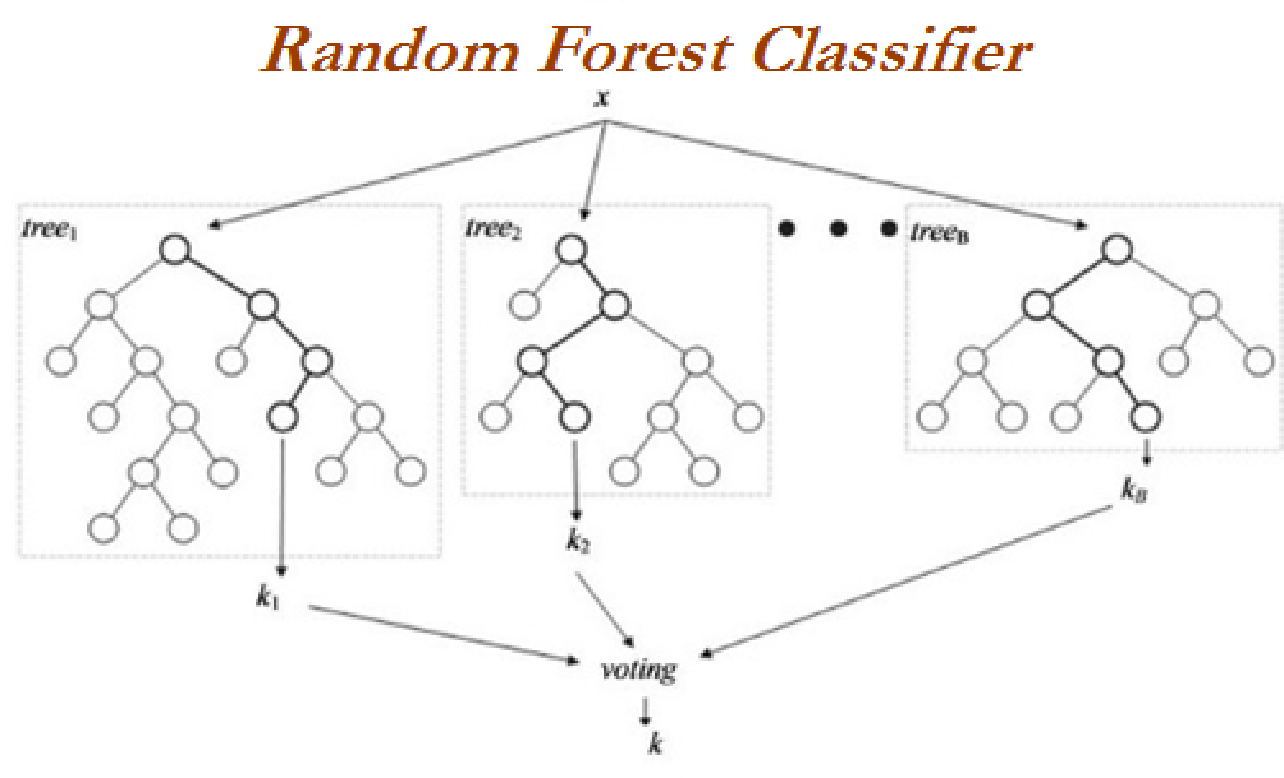

In [ ]:
RF = RandomForestClassifier()
RF.fit(x_train, y_train)

y_predict = RF.predict(x_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = accuracy_score(y_predict,y_test)
print(f"{round(RF_SC*100,2)}% Accurate")

##  XGBoost
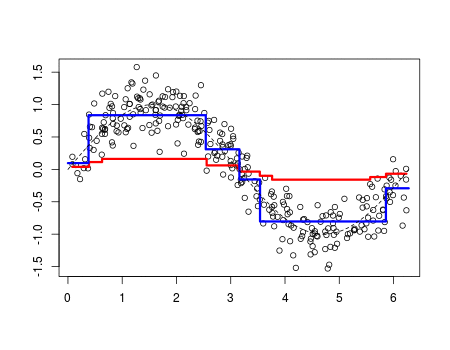

In [ ]:
XGB = XGBClassifier()
XGB.fit(x_train, y_train)

y_predict = XGB.predict(x_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
XGB_SC = accuracy_score(y_predict,y_test)
print(f"{round(XGB_SC*100,2)}% Accurate")

### Conclusion :
1. Credit_History is a very important variable because of its high correlation with Loan_Status therefor showind high Dependancy for the latter.
2. The Logistic Regression algorithm is the most accurate: approximately 83.76%.

In [ ]:
score = [DT_SC,RF_SC,XGB_SC,LR_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Random Forest","XGBoost", "Logistic Regression"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

If you found this notebook interesting please upvote!

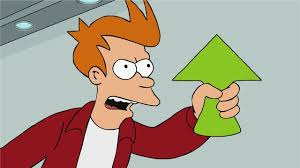